# Validating ToP 1min vs actual Actigraph counts

We use a sample raw acceleration measurement dataset from a GT3X+ Actigraph for which counts at various epochs, including 1 minute epoch, have been produced thanks to the official Actilife Software, ver 5.10.0

In [56]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
import top

root_datafolder = 'i:\\Benoit\\WORKSPACE\\INTERACT_data_pipeline\\data\\count_test_data'

## Loading Raw GT3X+ data

Header:

```
------------ Data File Created By ActiGraph GT3X+ ActiLife v5.10.0 Firmware v2.4.0 date format yyyy-MM-dd at 50 Hz  Filter Normal -----------
Serial Number: NEO1D24110312
Start Time 16:00:00
Start Date 2018-03-19
Epoch Period (hh:mm:ss) 00:00:00
Download Time 10:44:47
Download Date 2018-03-28
Current Memory Address: 0
Current Battery Voltage: 4.15     Mode = 12
--------------------------------------------------
```

In [57]:
# Load raw GT3X file
gt3x_fname = os.path.join(root_datafolder, 'Actigraph0\\NEO1D24110312 (2018-03-28)RAW.csv')
gt3x = pd.read_csv(gt3x_fname,
                   skiprows=10) # skip header
gt3x.index = pd.date_range(name='utcdate', start='2018-03-19 16:00:00', periods=len(gt3x.index), freq=f'{1/50:f}S')

print(gt3x)

                         Axis1  Axis2  Axis3
utcdate                                     
2018-03-19 16:00:00.000  1.009  0.091 -0.003
2018-03-19 16:00:00.020  1.012  0.091 -0.009
2018-03-19 16:00:00.040  1.012  0.091 -0.003
2018-03-19 16:00:00.060  1.012  0.091 -0.009
2018-03-19 16:00:00.080  1.012  0.091 -0.003
...                        ...    ...    ...
2018-03-28 10:44:57.420  0.000  0.000  0.000
2018-03-28 10:44:57.440  0.000  0.000  0.000
2018-03-28 10:44:57.460  0.000  0.000  0.000
2018-03-28 10:44:57.480  0.000  0.000  0.000
2018-03-28 10:44:57.500  0.000  0.000  0.000

[37934876 rows x 3 columns]


In [58]:
gt3x.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 37934876 entries, 2018-03-19 16:00:00 to 2018-03-28 10:44:57.500000
Freq: 20L
Data columns (total 3 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Axis1   float64
 1   Axis2   float64
 2   Axis3   float64
dtypes: float64(3)
memory usage: 1.1 GB


## Load Axtigraph 1min counts

This is our gold standard

In [59]:
agcnt = pd.read_csv(os.path.join(root_datafolder, r'Actigraph0\NEO1D24110312 (2018-03-28)60secDataTable.csv'), skiprows=1)
agcnt['utcdate'] = pd.to_datetime(agcnt['Date'] + ' ' + agcnt[' Time']) # Notice space before Time column name...
print(agcnt)

             Date      Time   Axis1  Axis2  Axis3  Steps  Lux  Inclinometer  \
0      2018-03-19  16:00:00       0      0      0      0    0             1   
1      2018-03-19  16:01:00       0      0      5      0    0             1   
2      2018-03-19  16:02:00       0      0      0      0    0             1   
3      2018-03-19  16:03:00       0      0      0      0    0             1   
4      2018-03-19  16:04:00      10      5     26      0    0             1   
...           ...       ...     ...    ...    ...    ...  ...           ...   
12639  2018-03-28  10:39:00       0      0      0      0  161             0   
12640  2018-03-28  10:40:00       0      0      0      0  153             0   
12641  2018-03-28  10:41:00       0      0      0      0  174             0   
12642  2018-03-28  10:42:00    1362   1581   1774     11   78             1   
12643  2018-03-28  10:43:00     811   1709    697     12  108             1   

       Vector Magnitude             utcdate  
0    

## Compute ToPs using INTERACT procedures

### 1 sec ToP

In [60]:
# Reformat GT3X df and generate dummy GPS file
gt3x = gt3x.rename(columns={'Axis1': 'x', 'Axis2': 'y', 'Axis3': 'z'}).reset_index()
gps = pd.DataFrame({'lat': 0, 'lon': 0, 'alt': 0}, 
                   index=pd.date_range(name='utcdate', start='2018-03-19 16:00:00', periods=100, freq=f'1S')).reset_index()


# Compute 1sec ToP
top1s = top._top_1sec('iid', 'sd', gps, gt3x)
print(top1s)

                    interact_id sd_id  count_x  count_y  count_z  count_vm  \
utcdate                                                                      
2018-03-19 16:00:00         iid    sd       30        0        0      30.0   
2018-03-19 16:00:01         iid    sd        0        0        0       0.0   
2018-03-19 16:00:02         iid    sd        0        0        0       0.0   
2018-03-19 16:00:03         iid    sd        0        0        0       0.0   
2018-03-19 16:00:04         iid    sd        0        0        0       0.0   
...                         ...   ...      ...      ...      ...       ...   
2018-03-28 10:44:53         iid    sd        0        0        0       0.0   
2018-03-28 10:44:54         iid    sd        0        0        0       0.0   
2018-03-28 10:44:55         iid    sd        0        0        0       0.0   
2018-03-28 10:44:56         iid    sd        0        0        0       0.0   
2018-03-28 10:44:57         iid    sd        0        0        0

In [61]:
print(top1s[['count_x', 'count_y', 'count_z', 'count_vm']].describe())

             count_x        count_y        count_z       count_vm
count  758698.000000  758698.000000  758698.000000  758698.000000
mean        2.099473       1.994653       2.431674       4.457543
std        11.256183       8.727783       9.976883      17.229156
min         0.000000       0.000000       0.000000       0.000000
25%         0.000000       0.000000       0.000000       0.000000
50%         0.000000       0.000000       0.000000       0.000000
75%         0.000000       0.000000       0.000000       0.000000
max       371.000000     376.000000     368.000000     474.017932


### 1 min ToP

In [62]:
# Compute 1min ToP
top1m = top._top_1min(top1s)
print(top1m)

                    interact_id sd_id  count_x  count_y  count_z     count_vm  \
utcdate                                                                         
2018-03-19 16:00:00         iid    sd       30        0        0    30.000000   
2018-03-19 16:01:00         iid    sd        0        0        4     4.000000   
2018-03-19 16:02:00         iid    sd        0        0        0     0.000000   
2018-03-19 16:03:00         iid    sd        0        0        0     0.000000   
2018-03-19 16:04:00         iid    sd       11        0       24    26.400758   
...                         ...   ...      ...      ...      ...          ...   
2018-03-28 10:40:00         iid    sd        0        0        0     0.000000   
2018-03-28 10:41:00         iid    sd        0        0        0     0.000000   
2018-03-28 10:42:00         iid    sd     1338     1608     1784  2749.284270   
2018-03-28 10:43:00         iid    sd      783     1764      683  2047.260120   
2018-03-28 10:44:00         

In [63]:
print(top1m[['count_x', 'count_y', 'count_z', 'count_vm']].describe())

            count_x       count_y       count_z      count_vm
count  12645.000000  12645.000000  12645.000000  12645.000000
mean     125.968051    119.678845    145.900040    247.399177
std      584.877732    350.792357    413.853639    791.632964
min        0.000000      0.000000      0.000000      0.000000
25%        0.000000      0.000000      0.000000      0.000000
50%        0.000000      0.000000      0.000000      0.000000
75%        0.000000      4.000000      9.000000     18.000000
max     6717.000000   3385.000000   3787.000000   7436.134345


## Comparing ToP 1min with Actigraph counts

In [64]:
cmp_cnt = top1m[['count_x', 'count_y', 'count_z', 'count_vm']].join(agcnt.set_index('utcdate'), how='inner')
cmp_cnt = cmp_cnt.drop(columns=['Date', ' Time', 'Steps', 'Lux', 'Inclinometer'])
print(cmp_cnt)


                     count_x  count_y  count_z     count_vm   Axis1  Axis2  \
utcdate                                                                      
2018-03-19 16:00:00       30        0        0    30.000000       0      0   
2018-03-19 16:01:00        0        0        4     4.000000       0      0   
2018-03-19 16:02:00        0        0        0     0.000000       0      0   
2018-03-19 16:03:00        0        0        0     0.000000       0      0   
2018-03-19 16:04:00       11        0       24    26.400758      10      5   
...                      ...      ...      ...          ...     ...    ...   
2018-03-28 10:39:00        0        0        0     0.000000       0      0   
2018-03-28 10:40:00        0        0        0     0.000000       0      0   
2018-03-28 10:41:00        0        0        0     0.000000       0      0   
2018-03-28 10:42:00     1338     1608     1784  2749.284270    1362   1581   
2018-03-28 10:43:00      783     1764      683  2047.260120     

### X axis

c:\Users\benoit\miniconda3\envs\py311_jupyter\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Model: ToP = 1.039 x Ag count + -0.703
R²: 0.999


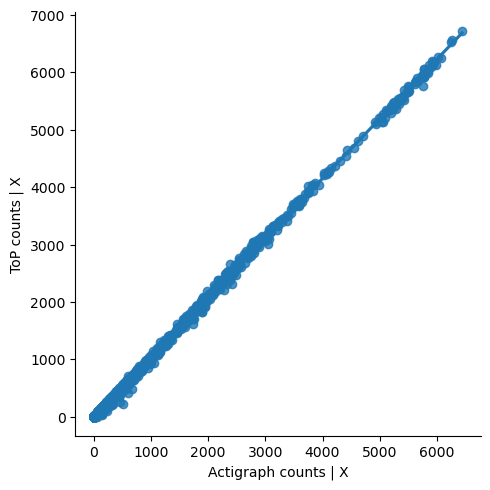

In [65]:
# Plot Axis 1
g = sns.lmplot(data=cmp_cnt,
               x=' Axis1', y='count_x')
g = g.set_axis_labels('Actigraph counts | X','ToP counts | X')

# Compute regresion
x = cmp_cnt[' Axis1'].array.reshape((-1, 1))
y = cmp_cnt['count_x']
model = LinearRegression().fit(x, y)
print(f'Model: ToP = {model.coef_[0]:.3f} x Ag count + {model.intercept_:.3f}')
print(f'R\u00B2: {model.score(x, y):.3f}')

### Y axis

c:\Users\benoit\miniconda3\envs\py311_jupyter\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Model: ToP = 1.035 x Ag count + -0.862
R²: 0.997


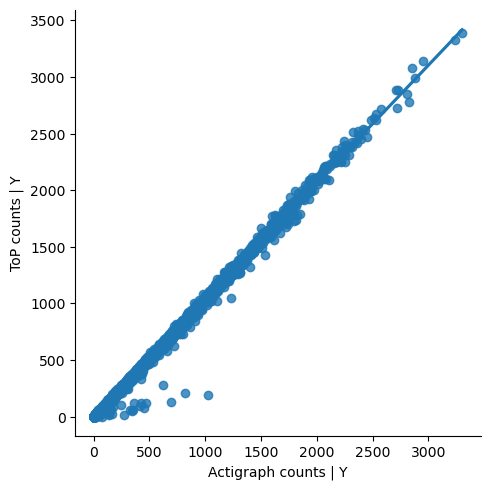

In [66]:
# Plot Axis 1
g = sns.lmplot(data=cmp_cnt,
               x='Axis2', y='count_y')
g = g.set_axis_labels('Actigraph counts | Y','ToP counts | Y')

# Compute regresion
x = cmp_cnt['Axis2'].array.reshape((-1, 1))
y = cmp_cnt['count_y']
model = LinearRegression().fit(x, y)
print(f'Model: ToP = {model.coef_[0]:.3f} x Ag count + {model.intercept_:.3f}')
print(f'R\u00B2: {model.score(x, y):.3f}')

### Z axis

c:\Users\benoit\miniconda3\envs\py311_jupyter\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Model: ToP = 1.041 x Ag count + -1.260
R²: 0.998


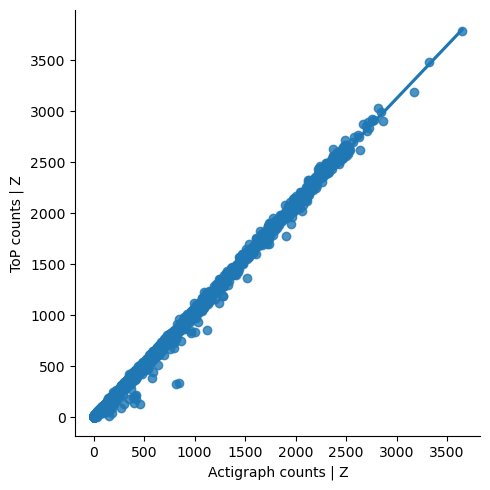

In [67]:
# Plot Axis 1
g = sns.lmplot(data=cmp_cnt,
               x='Axis3', y='count_z')
g = g.set_axis_labels('Actigraph counts | Z','ToP counts | Z')

# Compute regresion
x = cmp_cnt['Axis3'].array.reshape((-1, 1))
y = cmp_cnt['count_z']
model = LinearRegression().fit(x, y)
print(f'Model: ToP = {model.coef_[0]:.3f} x Ag count + {model.intercept_:.3f}')
print(f'R\u00B2: {model.score(x, y):.3f}')